In [13]:
import folium
import json
import os
import math
import requests
import pandas as pd
import numpy as np

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
#지하철 처리
#지하철 정보(4월한달)
API_KEY = '6261724242616e733837634f4e664c'
re=requests.get(f'http://openapi.seoul.go.kr:8088/{API_KEY}/json/CardSubwayStatsNew/1/999/20210401')

subway=dict()
for i in range(1,31):
    if i <10:
        re=requests.get(f'http://openapi.seoul.go.kr:8088/{API_KEY}/json/CardSubwayStatsNew/1/999/2021040{i}')
        data=re.json()
        date='2021040'+str(i)
    else:
        re=requests.get(f'http://openapi.seoul.go.kr:8088/{API_KEY}/json/CardSubwayStatsNew/1/999/202104{i}')
        data=re.json()
        date='202104' + str(i)
    station=[]
    take_on=[]
    take_off=[]
    for v in data['CardSubwayStatsNew']['row']:
        if v['LINE_NUM']=='9호선':
                station.append(v['SUB_STA_NM'])
                take_on.append(v['RIDE_PASGR_NUM'])
                take_off.append(v['ALIGHT_PASGR_NUM'])
    subway[date]=[
        {'station':station,'승차인원':take_on,'하차인원':take_off}
    ]
    
df=pd.DataFrame(index=subway['20210401'][0]['station'],columns=subway.keys())
for i in subway:
    for v in subway[i]:
        df[i]=v['승차인원']
ride=pd.DataFrame(df.mean(axis=1),columns=['평균 승차 승객 수'])

fd=pd.DataFrame(index=subway['20210401'][0]['station'],columns=subway.keys())
for i in subway:
    for v in subway[i]:
        fd[i]=v['하차인원']
off=pd.DataFrame(fd.mean(axis=1),columns=['평균 하차 승객 수'])

table=pd.merge(left=ride,right=off,how='inner',left_on=ride.index,right_on=off.index)
table['평균 이용객 수'] = table.sum(axis=1)
table= table.drop(['평균 승차 승객 수', '평균 하차 승객 수'], axis=1)
table=table.rename(columns={'key_0':'역명'})
table=table.sort_values(by='평균 이용객 수',ascending=False)

In [16]:
#선유도~ 영쳔향교 승하차 수 시각화
subway_data = table['역명'].str.contains("양천향교|가양|증미|등촌|염창|신목동|선유도")
subset_df = table[subway_data]
subset_df['평균 이용객 수'] = subset_df['평균 이용객 수'].astype(int)
subset_df = subset_df.sort_values(by='평균 이용객 수', ascending=False)
subset_df.head(7)

,역명,평균 이용객 수
6,가양,35118
9,염창,29687
8,등촌,19433
5,양천향교,16877
11,선유도,13512
7,증미,12579
10,신목동,6535


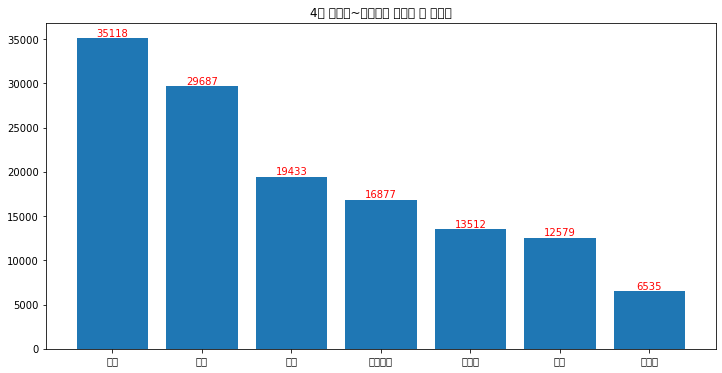

In [17]:
from matplotlib import pyplot as plt
import matplotlib.font_manager
import matplotlib as mpl

plt.figure(figsize=(12,6))

plt.bar(subset_df['역명'], subset_df['평균 이용객 수'])
for x,y in enumerate(list(subset_df['평균 이용객 수'])):
    plt.text(x, y, y, fontsize=10, color='#ff0000', 
                    horizontalalignment='center', verticalalignment='bottom')
plt.title('4월 선유도~영천향교 승하차 수 시각화')
plt.show()

In [18]:
#지하철역 경위도 가져오기
import re
subset_df['역명']=subset_df['역명'].apply(lambda x: re.sub(r'\([^)]*\)', '', x) if '(' in x else x)
subset_df['역명']=subset_df['역명'].apply(lambda x: x+'역')
x=[]
y=[]
subset_df.head()

,역명,평균 이용객 수
6,가양역,35118
9,염창역,29687
8,등촌역,19433
5,양천향교역,16877
11,선유도역,13512


In [19]:
for z in subset_df['역명']:

    url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query={}'.format(z)
    headers = {
        "Authorization": "KakaoAK 9608ae74878b248012eeace9eb174798"
    }
#json 형태로 데이터가 주어진다
    places = requests.get(url, headers = headers).json()['documents'][0]
    x.append(places['y'])
    y.append(places['x'])
    
subset_df['latitude']=x
subset_df['longitude']=y
passenger_data=subset_df.reset_index()    
passenger_data['평균 이용객 수']=passenger_data['평균 이용객 수'].astype(float)
passenger_data.drop('index', axis=1, inplace=True)
passenger_data.head()

,역명,평균 이용객 수,latitude,longitude
0,가양역,35118.0,37.5614331158033,126.854420294338
1,염창역,29687.0,37.546982941543,126.874871603971
2,등촌역,19433.0,37.5507280806214,126.865572139231
3,양천향교역,16877.0,37.5680808809647,126.841978835328
4,선유도역,13512.0,37.538156854068,126.893333867069


In [20]:
#1차로 지하철 이용객 수 표시
#passenger_data를 기반으로 Folium 그리기
# 위치 파라미터 설정
loc = [37.5581321602446, 126.860637888459] # 위도(N), 경도(E)

# 지도 정의
map_subway = folium.Map(location=loc, zoom_start=13)
#map_ediya.choropleth(geo_data=geo_str,
              #data = ediya_gu['상호명'],
              #columns=[ediya_gu.index, ediya_gu['상호명']],
              #fill_color='PuRd',
              #key_on='feature.id')
for i in passenger_data.index:
    folium.CircleMarker([float(passenger_data['latitude'][i]),float(passenger_data['longitude'][i])], radius=passenger_data['평균 이용객 수'][i]/2000, popup=folium.Popup(passenger_data['역명'][i]+' 평균이용객수 :'+str(passenger_data['평균 이용객 수'][i]), max_width=300),color='#3186cc', fill_color='#3186cc').add_to(map_subway)

In [21]:
#지도 표시 영역은 이용객수에따라 크기가 다르고 영역 을 클릭하면 역의 이름과 이용객 수가 표기된다
map_subway

In [22]:
#이디야와 공영주차장 위치 구하기
#1. 공영주차장 처리
url=f'http://openapi.seoul.go.kr:8088/{API_KEY}/json/GetParkInfo/1/2/'
re=requests.get(url)
rjson=re.json()
total_num=int(rjson['GetParkInfo']['list_total_count'])

In [23]:
# json데이터를 프레임화
parking_name=[]
lat=[]
long=[]


for i in range(1, math.ceil(total_num/1000)+1):
    
    end=i*1000
    start=end-1000 +1
    
    if end >total_num:
        end = total_num
        
    url=f'http://openapi.seoul.go.kr:8088/{API_KEY}/json/GetParkInfo/{start}/{end}'
    re=requests.get(url)
    rjson=re.json()
    
    for u in rjson['GetParkInfo']['row']:
        parking_name.append(u['PARKING_NAME'])
        lat.append(u['LAT'])
        long.append(u['LNG'])
        
    park_df=pd.DataFrame({'주차장 명':parking_name,'위도':lat,'경도':long})
park_df.head()

,주차장 명,위도,경도
0,초안산근린공원주차장(구),37.649279,127.040474
1,마들스타디움(근린공원)(구),37.643917,127.058567
2,마장동공영주차장(구),37.569939,127.035145
3,영등포여고 공영(구),37.515205,126.915116
4,당산근린공원 공영(구),37.525526,126.895794


In [24]:
#이디야 위치 저장
df = pd.read_csv('./data/cafe_data.csv', engine='python', encoding='utf-8')

In [25]:
print('컬럼 항목 수 :', len(df.columns))
list(df.columns)

컬럼 항목 수 : 39


['상가업소번호',
 '상호명',
 '지점명',
 '상권업종대분류코드',
 '상권업종대분류명',
 '상권업종중분류코드',
 '상권업종중분류명',
 '상권업종소분류코드',
 '상권업종소분류명',
 '표준산업분류코드',
 '표준산업분류명',
 '시도코드',
 '시도명',
 '시군구코드',
 '시군구명',
 '행정동코드',
 '행정동명',
 '법정동코드',
 '법정동명',
 '지번코드',
 '대지구분코드',
 '대지구분명',
 '지번본번지',
 '지번부번지',
 '지번주소',
 '도로명코드',
 '도로명',
 '건물본번지',
 '건물부번지',
 '건물관리번호',
 '건물명',
 '도로명주소',
 '구우편번호',
 '신우편번호',
 '동정보',
 '층정보',
 '호정보',
 '경도',
 '위도']

In [26]:
print('='*70)
print('상권업종대분류명', set(df['상권업종대분류명']))
print('='*70)
print('상권업종중분류명', set(df['상권업종중분류명']))
print('='*70)

상권업종대분류명 {'생활서비스', '음식', '스포츠', '관광/여가/오락', '학문/교육', '소매', '숙박', '부동산'}
상권업종중분류명 {'장례/묘지', '운영관리시설', '자동차/이륜차', '광고/인쇄', '커피점/카페', '학원-창업취업취미', '가정/주방/인테리어', '유아교육', '무도/유흥/가무', '학원-어학', '캠프/별장/펜션', '기타판매업', '중고품소매/교환', '양식', '철물/난방/건설자재소매', '제과제빵떡케익', '전시/관람', '시계/귀금속소매', '기타음식업', '자동차/자동차용품', '경마/경륜/성인오락', '대중목욕탕/휴게', '분식', '부동산중개', '유스호스텔', '스포츠/운동', '부동산관련서비스', '학원-보습교습입시', '예식/의례/관혼상제', '기타서비스업', '음/식료품소매', '물품기기대여', '이/미용/건강', '주택수리', 'PC/오락/당구/볼링등', '학원-컴퓨터', '부동산임대', '세탁/가사서비스', '연극/영화/극장', '모텔/여관/여인숙', '기타교육기관', '행사/이벤트', '특수교육기관', '민박/하숙', '법무세무회계', '사진/광학/정밀기기소매', '유아용품', '패스트푸드', '가방/신발/액세서리', '요가/단전/마사지', '애견/애완/동물', '대행업', '사무/문구/컴퓨터', '학문교육기타', '페인트/유리제품소매', '종교용품판매', '실내운동시설', '음식배달서비스', '취미/오락관련소매', '예술품/골동품/수석/분재', '선물/팬시/기념품', '학원-음악미술무용', '부페', '중식', '놀이/여가/취미', '한식', '의약/의료품소매', '화장품소매', '학원기타', '분양', '책/서적/도서', '의복의류', '개인/가정용품수리', '호텔/콘도', '도서관/독서실', '사진', '유흥주점', '학원-자격/국가고시', '닭/오리요리', '인력/고용/용역알선', '가구소매', '별식/퓨전요리', '학원-예능취미체육', '평가/개발/관리', '종합소매점', '운송/배달/택배

In [27]:
dataset = df[['상호명','지점명',
              '상권업종대분류명', '상권업종중분류명',
              '시도명', '시군구명', '행정동명',
              '위도', '경도']]

dataset.head()

,상호명,지점명,상권업종대분류명,상권업종중분류명,시도명,시군구명,행정동명,위도,경도
0,비지트,NaN,음식,한식,서울특별시,서초구,방배4동,37.488375,126.991394
1,쓰리에프,NaN,음식,한식,서울특별시,동작구,사당2동,37.487105,126.980952
2,채움,NaN,음식,한식,서울특별시,종로구,종로1.2.3.4가동,37.572387,126.981794
3,호구의주방,NaN,소매,가정/주방/인테리어,서울특별시,영등포구,양평2동,37.536700,126.897892
4,BYC상신점,상신점,소매,의복의류,서울특별시,송파구,거여2동,37.493054,127.147321


In [28]:
df = dataset[(dataset['상권업종중분류명']=='커피점/카페')&(dataset['시도명']=='서울특별시')]
df.index = range(len(df))
print('서울시 내 커피 전문점 점포 수 :', len(df))
df.head()

서울시 내 커피 전문점 점포 수 : 21048


,상호명,지점명,상권업종대분류명,상권업종중분류명,시도명,시군구명,행정동명,위도,경도
0,커피빈,코리아대학로대명거리점,음식,커피점/카페,서울특별시,종로구,혜화동,37.583149,127.000171
1,요거프레소,쌍문점,음식,커피점/카페,서울특별시,도봉구,쌍문2동,37.658728,127.034746
2,메머드커피,NaN,음식,커피점/카페,서울특별시,마포구,서교동,37.554599,126.929692
3,버블베어,NaN,음식,커피점/카페,서울특별시,강서구,방화3동,37.580941,126.813358
4,우성커피숍,NaN,음식,커피점/카페,서울특별시,양천구,신월4동,37.522055,126.842935


In [29]:
df_ediya = df[df['상호명'].str.contains('이디야')]
df_ediya.index = range(len(df_ediya))
print('서울시 내 이디야 점포 수 :', len(df_ediya))
#이디야의 경우 지점명, 위도,경도말고 사용을 안하니 다 드랍
df_ediya = df_ediya.drop(['상호명','상권업종대분류명', '상권업종중분류명','시도명', '시군구명', '행정동명',],axis=1)
df_ediya.head()

서울시 내 이디야 점포 수 : 457


,지점명,위도,경도
0,신길역점,37.515118,126.918062
1,라이프점,37.519544,126.939198
2,양재AT점,37.469075,127.040265
3,시흥점,37.449066,126.913646
4,개봉중앙점,37.486436,126.854872


In [30]:
#이제 해당 역세권범위안에있는 공영주차장과 이디야의 수구하기(0.5km이내)
!pip install haversine
from haversine import haversine

In [31]:
ediya_counts =[]
ediyas_indexes=[]
park_indexes=[]
park_counts=[]

for i in passenger_data.index:
    ediya_count = 0;
    prak_count =0;
    subway = (float(passenger_data['latitude'][i]),float(passenger_data['longitude'][i]))
    for j in df_ediya.index:
        ediya = (float(df_ediya['위도'][j]),float(df_ediya['경도'][j]))
        dist = haversine(subway,ediya, unit='m')
        if(dist<500):
            ediyas_indexes.append(j)
            ediya_count = ediya_count+1
        
    ediya_counts.append(ediya_count)
    for j in park_df.index:
        park = (float(park_df['위도'][j]),float(park_df['경도'][j]))
        dist = haversine(subway,park, unit='m')
        if(dist<500):
            park_indexes.append(j)
            prak_count = prak_count+1
    park_counts.append(prak_count)
    
passenger_data['주변 이디야 수'] = pd.DataFrame(np.transpose(ediya_counts))

passenger_data['주변 공영주차장 수'] = pd.DataFrame(np.transpose(park_counts))

passenger_data.head(7)

,역명,평균 이용객 수,latitude,longitude,주변 이디야 수,주변 공영주차장 수
0,가양역,35118.0,37.5614331158033,126.854420294338,0,15
1,염창역,29687.0,37.546982941543,126.874871603971,2,2
2,등촌역,19433.0,37.5507280806214,126.865572139231,4,2
3,양천향교역,16877.0,37.5680808809647,126.841978835328,3,1
4,선유도역,13512.0,37.538156854068,126.893333867069,1,7
5,증미역,12579.0,37.5581321602446,126.860637888459,1,7
6,신목동역,6535.0,37.5442883741577,126.883095790252,0,0


In [32]:
map_nearsubway = folium.Map(location=loc, zoom_start=13)
for i in passenger_data.index:
    folium.Circle([float(passenger_data['latitude'][i]),float(passenger_data['longitude'][i])], radius=500, popup=folium.Popup(passenger_data['역명'][i]+' 평균이용객수 :'+str(passenger_data['평균 이용객 수'][i]), max_width=300),color='#3186cc', fill_color='#3186cc').add_to(map_nearsubway)
for i in ediyas_indexes:
    folium.Marker([float(df_ediya['위도'][i]),float(df_ediya['경도'][i])],popup=folium.Popup(df_ediya['지점명'][i]),icon=folium.Icon(color='blue')).add_to(map_nearsubway)
for i in park_indexes:
    folium.Marker([float(park_df['위도'][i]),float(park_df['경도'][i])],popup=folium.Popup(park_df['주차장 명'][i]),icon=folium.Icon(color='red')).add_to(map_nearsubway)
map_nearsubway

In [33]:
#지도를 통해 정답이 가양역이라는 사실을 알았으나 조건문을 통한 체크로 검증
#승객수는 제외하고 일단 공영주차장이 1개 이상인지 체크, 그다음 주변 이디야 수가 더 적은곳, 그다음 이용객수가 더 큰곳
subwaystation=""
mimun_count= 1000000
max_passenger_count=0
for i in passenger_data.index:
    if(passenger_data['주변 공영주차장 수'][i]>1):
        currnet_count=  passenger_data['주변 이디야 수'][i]
        #주변이디야가 가장적은곳으로 선정
        if(mimun_count>passenger_data['주변 이디야 수'][i]):
            mimun_count = passenger_data['주변 이디야 수'][i]
            max_passenger_count = passenger_data['평균 이용객 수'][i]
            subwaystation = passenger_data['역명'][i]
        # 주변에 있는 이디야의 수가 같다면 더 이용객이 많은곳을 선정
        elif((mimun_count ==currnet_count)and(passenger_data['평균 이용객 수'][i]>max_passenger_count)):
            max_passenger_count=passenger_data['평균 이용객 수'][i]
            subwaystation = passenger_data['역명'][i]
print(subwaystation)      

가양역
